In [1]:
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder 

#os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']


2024-03-25 22:07:18.944708: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# from tensorflow.keras.utils import to_categorical
# from sklearn.datasets import fetch_openml
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder, StandardScaler
# import numpy as np

# %matplotlib inline
# seed = 0
# np.random.seed(seed)
# import tensorflow as tf

# tf.random.set_seed(seed)
# import os

# os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']

In [3]:
DATA_DIR = "PokerDataset"  
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
TEST_SIZE = 0.2
NUM_CLASSES = 52

In [4]:
image_paths = []
labels = []


In [5]:
for label in os.listdir(DATA_DIR):
    label_dir = os.path.join(DATA_DIR, label)
    for image_file in os.listdir(label_dir):
        image_paths.append(os.path.join(label_dir, image_file))
        labels.append(label)

In [6]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    image_paths, labels, test_size=TEST_SIZE, random_state=42, stratify=labels)

In [7]:
# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(y_train_val)
y_train_val_encoded = label_encoder.transform(y_train_val)
y_test_encoded = label_encoder.transform(y_test)

In [8]:
# Convert integer labels to categorical format
y_train_val = to_categorical(y_train_val_encoded, NUM_CLASSES)

# Convert integer labels to categorical format
y_test = to_categorical(y_test_encoded, NUM_CLASSES)

In [9]:
# Verify one-hot encoding
print("Shape of y_train_val:", y_train_val.shape)
print("Shape of y_test:", y_test.shape)

Shape of y_train_val: (624, 52)
Shape of y_test: (156, 52)


In [10]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(IMAGE_WIDTH, IMAGE_HEIGHT))
    img_array = img_to_array(img) / 255.0  # Normalize pixel values
    return img_array

In [11]:
X_train_val = [preprocess_image(image_path) for image_path in X_train_val]
X_test = [preprocess_image(image_path) for image_path in X_test]

In [12]:
X_train_val = np.array(X_train_val)
X_test = np.array(X_test)

In [13]:
# Save the preprocessed data
np.save('X_train_val.npy', X_train_val)
np.save('X_test.npy', X_test)
np.save('y_train_val.npy', y_train_val)
np.save('y_test.npy', y_test)
np.save('classes.npy', label_encoder.classes_)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks


In [15]:
model = Sequential()
model.add(Conv2D(4, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), name='conv1'))
model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool1'))
model.add(Conv2D(8, (3, 3), activation='relu', name='conv2'))
model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2'))
model.add(Flatten(name='flatten'))
model.add(Dense(32, activation='relu', name='dense1'))
model.add(Dense(NUM_CLASSES, activation='softmax', name='output'))




print("Model summary:")
model.summary()

2024-03-25 22:07:23.804702: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model summary:
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 62, 62, 4)         112       
                                                                 
 maxpool1 (MaxPooling2D)     (None, 31, 31, 4)         0         
                                                                 
 conv2 (Conv2D)              (None, 29, 29, 8)         296       
                                                                 
 maxpool2 (MaxPooling2D)     (None, 14, 14, 8)         0         
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense1 (Dense)              (None, 32)                50208     
                                                                 
 output (Dense)              (None, 52)  

In [16]:
train = True
if train:
    adam = Adam(lr=0.01)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='model_1',
    )
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=10,
        epochs=50,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
else:
    from tensorflow.keras.models import load_model

    model = load_model('model_1/KERAS_check_best_model.h5')

Epoch 1/50
45/47 [===========================>..] - ETA: 0s - loss: 3.9659 - accuracy: 0.0156
***callbacks***
saving losses to model_1/losses.log

Epoch 1: val_loss improved from inf to 3.95097, saving model to model_1/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 3.95097, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_1/KERAS_check_model_last.h5

Epoch 1: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 3s 22ms/step - loss: 3.9658 - accuracy: 0.0150 - val_loss: 3.9510 - val_accuracy: 0.0064 - lr: 0.0010
Epoch 2/50
46/47 [============================>.] - ETA: 0s - loss: 3.9250 - accuracy: 0.0391
***callbacks***
saving losses to model_1/losses.log

Epoch 2: val_loss did not improve from 3.95097

Epoch 2: val_loss did not improve from 3.95097

Epoch 2: saving model to model_1/KERAS_check_model_last.h5

Epoch 2: saving model to model_1/KERAS_check_model_l

Epoch 14/50
46/47 [============================>.] - ETA: 0s - loss: 0.6473 - accuracy: 0.8370
***callbacks***
saving losses to model_1/losses.log

Epoch 14: val_loss improved from 2.38028 to 2.28548, saving model to model_1/KERAS_check_best_model.h5

Epoch 14: val_loss improved from 2.38028 to 2.28548, saving model to model_1/KERAS_check_best_model_weights.h5

Epoch 14: saving model to model_1/KERAS_check_model_last.h5

Epoch 14: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 1s 15ms/step - loss: 0.6446 - accuracy: 0.8397 - val_loss: 2.2855 - val_accuracy: 0.4423 - lr: 0.0010
Epoch 15/50
46/47 [============================>.] - ETA: 0s - loss: 0.5108 - accuracy: 0.8804
***callbacks***
saving losses to model_1/losses.log

Epoch 15: val_loss did not improve from 2.28548

Epoch 15: val_loss did not improve from 2.28548

Epoch 15: saving model to model_1/KERAS_check_model_last.h5

Epoch 15: saving model to model_1/K


Epoch 28: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 1s 13ms/step - loss: 0.0303 - accuracy: 1.0000 - val_loss: 2.6533 - val_accuracy: 0.5897 - lr: 5.0000e-04
Epoch 29/50
46/47 [============================>.] - ETA: 0s - loss: 0.0278 - accuracy: 1.0000
***callbacks***
saving losses to model_1/losses.log

Epoch 29: val_loss did not improve from 2.26762

Epoch 29: val_loss did not improve from 2.26762

Epoch 29: saving model to model_1/KERAS_check_model_last.h5

Epoch 29: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 1s 13ms/step - loss: 0.0278 - accuracy: 1.0000 - val_loss: 2.6189 - val_accuracy: 0.5833 - lr: 5.0000e-04
Epoch 30/50
42/47 [=========================>....] - ETA: 0s - loss: 0.0257 - accuracy: 1.0000
***callbacks***
saving losses to model_1/losses.log

Epoch 30: val_loss did not improve from 2.26762

Epoch 30: val_loss di


Epoch 43: val_loss did not improve from 2.26762

Epoch 43: saving model to model_1/KERAS_check_model_last.h5

Epoch 43: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 1s 14ms/step - loss: 0.0135 - accuracy: 1.0000 - val_loss: 2.8378 - val_accuracy: 0.5833 - lr: 2.5000e-04
Epoch 44/50
45/47 [===========================>..] - ETA: 0s - loss: 0.0129 - accuracy: 1.0000
***callbacks***
saving losses to model_1/losses.log

Epoch 44: val_loss did not improve from 2.26762

Epoch 44: val_loss did not improve from 2.26762

Epoch 44: saving model to model_1/KERAS_check_model_last.h5

Epoch 44: saving model to model_1/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 1s 13ms/step - loss: 0.0130 - accuracy: 1.0000 - val_loss: 2.8653 - val_accuracy: 0.5962 - lr: 2.5000e-04
Epoch 45/50
43/47 [==========================>...] - ETA: 0s - loss: 0.0124 - accuracy: 1.0000
***callbacks*

5/5 [==============================] - 0s 8ms/step
Accuracy: 0.5961538461538461


/home/esp2024/rht2122/PokerML/PokerML/plotting.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = y[:, i]
/home/esp2024/rht2122/PokerML/PokerML/plotting.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label + '_pred'] = predict_test[:, i]
/home/esp2024/rht2122/PokerML/PokerML/plotting.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

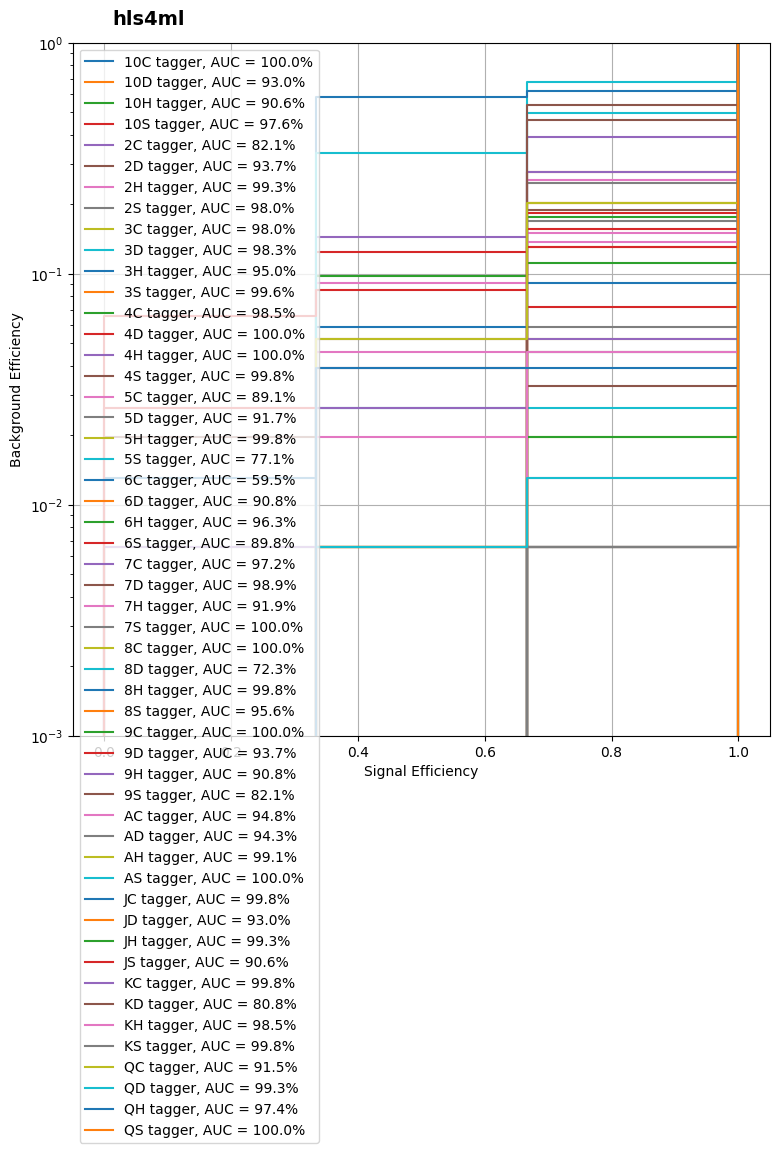

In [17]:
import plotting
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

y_keras = model.predict(X_test)
print("Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
plt.figure(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, label_encoder.classes_)

In [18]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(model, granularity='model')
print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_1/hls4ml_prj', part='xcu250-figd2104-2L-e'
)

/home/esp2024/rht2122/miniconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, input shapes: [[None, 64, 64, 3]], output shape: [None, 64, 64, 3]
Layer name: conv1, layer type: Conv2D, input shapes: [[None, 64, 64, 3]], output shape: [None, 62, 62, 4]
Layer name: maxpool1, layer type: MaxPooling2D, input shapes: [[None, 62, 62, 4]], output shape: [None, 31, 31, 4]
Layer name: conv2, layer type: Conv2D, input shapes: [[None, 31, 31, 4]], output shape: [None, 29, 29, 8]
Layer name: maxpool2, layer type: MaxPooling2D, input shapes: [[None, 29, 29, 8]], output shape: [None, 14, 14, 8]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 14, 14, 8]], output shape: [None, 1568]
Layer name: dense1, layer type: Dense, input shapes: [[None, 1568]], output shape: [None, 32]
Layer name: output, layer type: Dense, input shapes: [[None, 32]], output shape: [None, 52]
-----------------------------------
Configuration
Model
  Precision:         fixed<16,6>
  ReuseFactor:       1
  Stra

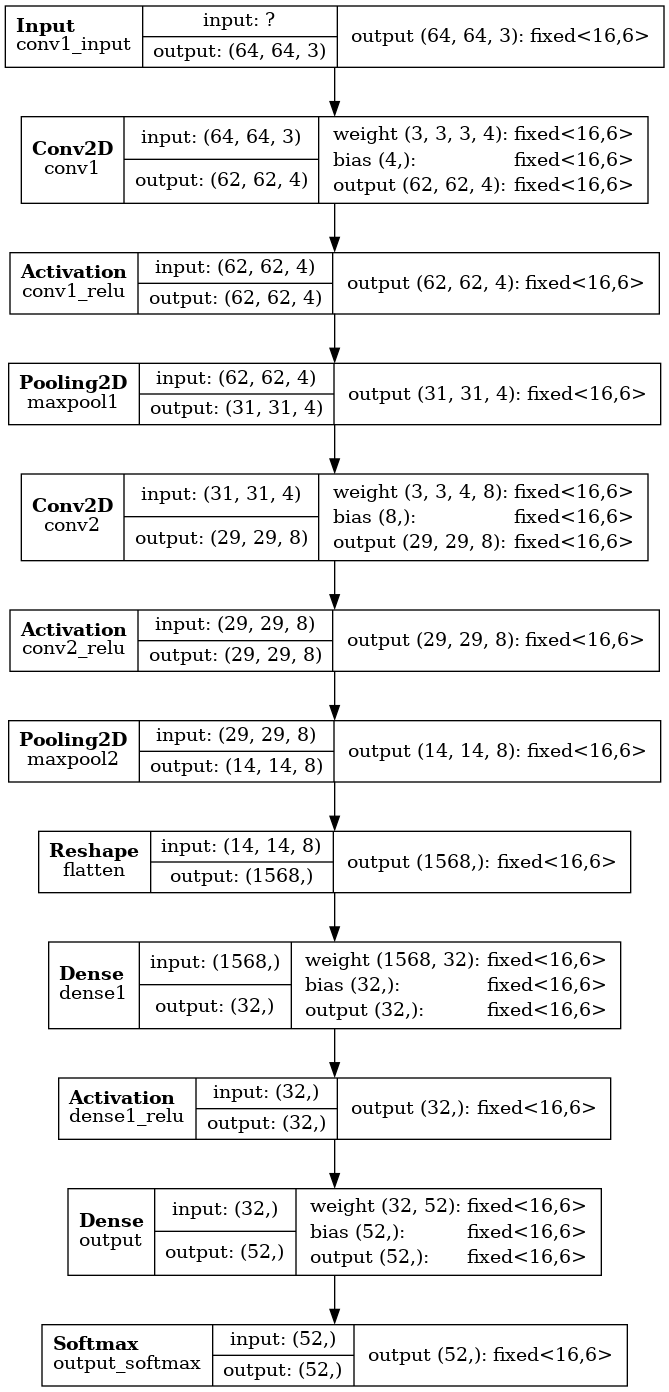

In [19]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)


In [20]:
hls_model.compile()
X_test = np.ascontiguousarray(X_test)
y_hls = hls_model.predict(X_test)

print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))


Writing HLS project
Done
Keras  Accuracy: 0.5961538461538461
hls4ml Accuracy: 0.14743589743589744


/home/esp2024/rht2122/PokerML/PokerML/plotting.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = y[:, i]
/home/esp2024/rht2122/PokerML/PokerML/plotting.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label + '_pred'] = predict_test[:, i]
/home/esp2024/rht2122/PokerML/PokerML/plotting.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

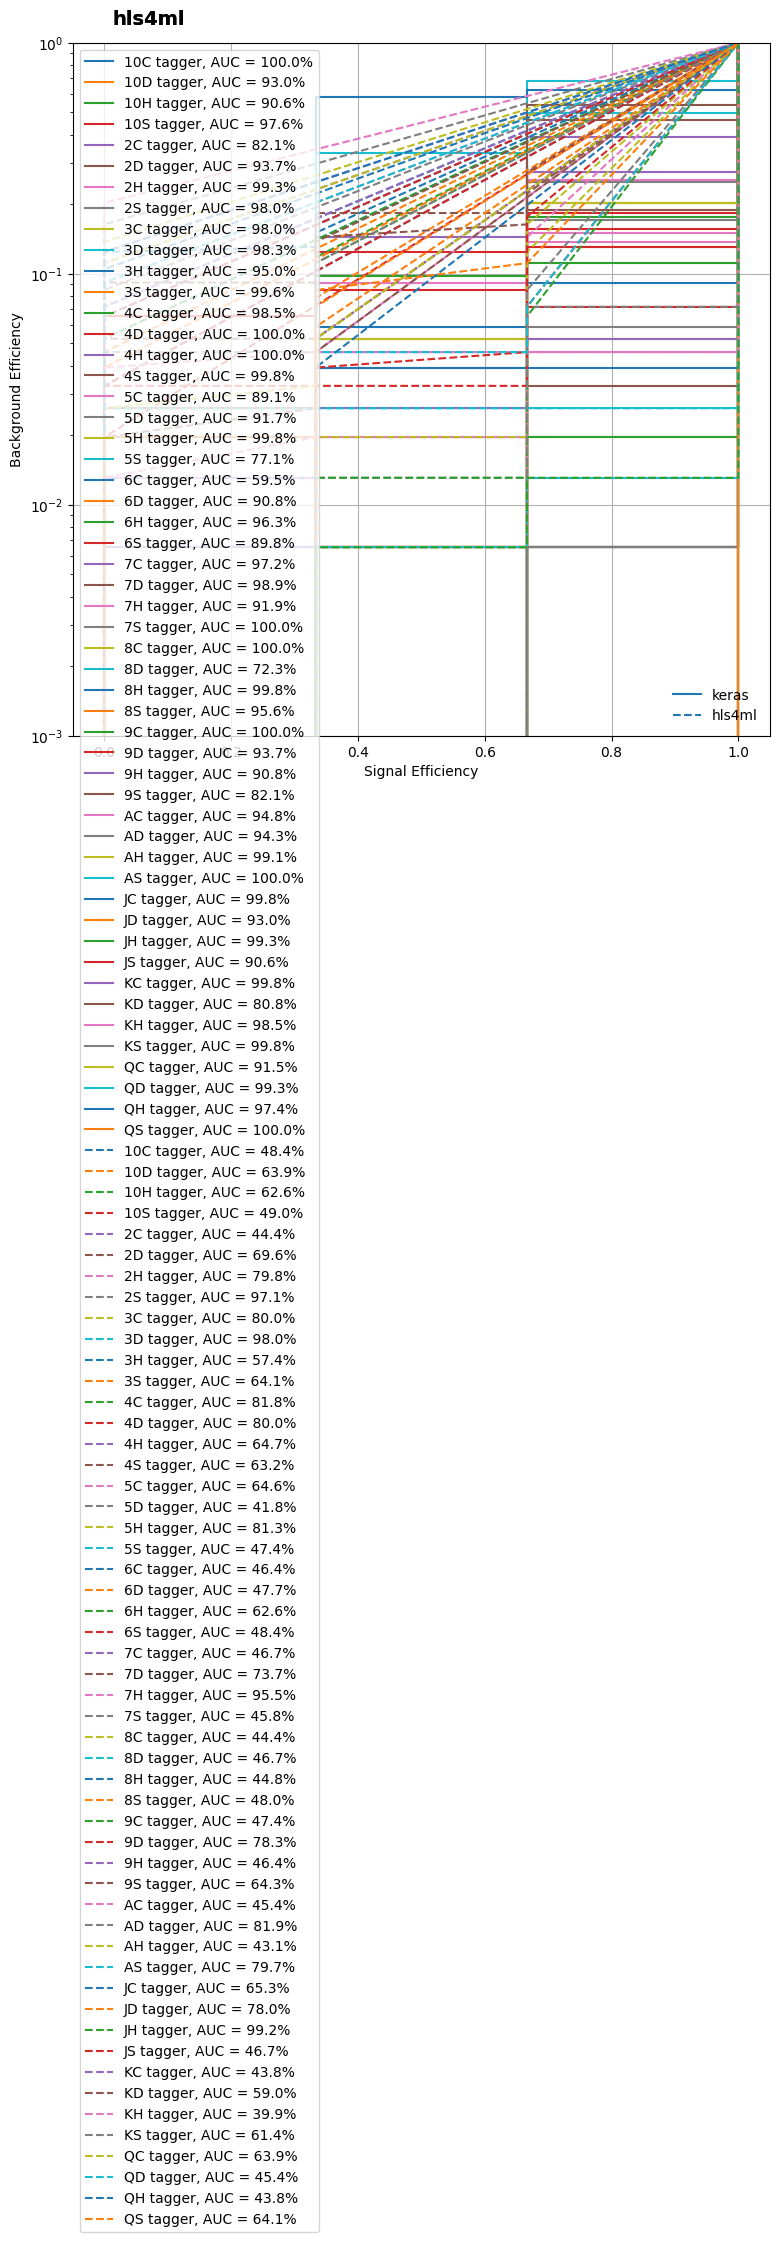

In [21]:
fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_keras, label_encoder.classes_)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, label_encoder.classes_, linestyle='--')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['keras', 'hls4ml'], loc='lower right', frameon=False)
ax.add_artist(leg)

Quantization Model

In [22]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
seed = 0
np.random.seed(seed)
import tensorflow as tf

tf.random.set_seed(seed)
import os

In [23]:
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy')
classes = np.load('classes.npy', allow_pickle=True)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks
from tensorflow.keras.layers import Activation
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu

In [25]:
model = Sequential()
model.add(Conv2D(4, (3, 3), input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), name='conv1'))
model.add(QActivation(activation=quantized_relu(6), name='relu1'))
model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool1'))
model.add(Conv2D(8, (3, 3), name='conv2'))
model.add(QActivation(activation=quantized_relu(6), name='relu2'))
model.add(MaxPooling2D(pool_size=(2, 2), name='maxpool2'))
model.add(Flatten(name='flatten'))
model.add(Dense(32,name='dense1'))
model.add(QActivation(activation=quantized_relu(6), name='relu3'))
model.add(Dense(NUM_CLASSES, activation='softmax', name='output'))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [26]:
train = True
if train:
    adam = Adam(lr=0.01)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    callbacks = all_callbacks(
        stop_patience=1000,
        lr_factor=0.5,
        lr_patience=10,
        lr_epsilon=0.000001,
        lr_cooldown=2,
        lr_minimum=0.0000001,
        outputDir='model_2',
    )
    model.fit(
        X_train_val,
        y_train_val,
        batch_size=10,
        epochs=50,
        validation_split=0.25,
        shuffle=True,
        callbacks=callbacks.callbacks,
    )
    

else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects

    co = {}
    _add_supported_quantized_objects(co)
    model = load_model('model_2/KERAS_check_best_model.h5', custom_objects=co)

Epoch 1/50
44/47 [===========================>..] - ETA: 0s - loss: 3.9714 - accuracy: 0.0136
***callbacks***
saving losses to model_2/losses.log

Epoch 1: val_loss improved from inf to 3.95402, saving model to model_2/KERAS_check_best_model.h5

Epoch 1: val_loss improved from inf to 3.95402, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 1: saving model to model_2/KERAS_check_model_last.h5

Epoch 1: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 3s 36ms/step - loss: 3.9697 - accuracy: 0.0150 - val_loss: 3.9540 - val_accuracy: 0.0064 - lr: 0.0010
Epoch 2/50
46/47 [============================>.] - ETA: 0s - loss: 3.9334 - accuracy: 0.0326
***callbacks***
saving losses to model_2/losses.log

Epoch 2: val_loss improved from 3.95402 to 3.94450, saving model to model_2/KERAS_check_best_model.h5

Epoch 2: val_loss improved from 3.95402 to 3.94450, saving model to model_2/KERAS_check_best_model_weight


Epoch 13: saving model to model_2/KERAS_check_model_last.h5

Epoch 13: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 1s 19ms/step - loss: 2.9649 - accuracy: 0.4444 - val_loss: 3.2508 - val_accuracy: 0.1538 - lr: 0.0010
Epoch 14/50
44/47 [===========================>..] - ETA: 0s - loss: 2.8815 - accuracy: 0.4841
***callbacks***
saving losses to model_2/losses.log

Epoch 14: val_loss improved from 3.25078 to 3.19100, saving model to model_2/KERAS_check_best_model.h5

Epoch 14: val_loss improved from 3.25078 to 3.19100, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 14: saving model to model_2/KERAS_check_model_last.h5

Epoch 14: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 1s 18ms/step - loss: 2.8854 - accuracy: 0.4808 - val_loss: 3.1910 - val_accuracy: 0.2115 - lr: 0.0010
Epoch 15/50
46/47 [============================

Epoch 26/50
45/47 [===========================>..] - ETA: 0s - loss: 2.0388 - accuracy: 0.7489
***callbacks***
saving losses to model_2/losses.log

Epoch 26: val_loss improved from 2.71442 to 2.65221, saving model to model_2/KERAS_check_best_model.h5

Epoch 26: val_loss improved from 2.71442 to 2.65221, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 26: saving model to model_2/KERAS_check_model_last.h5

Epoch 26: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 1s 18ms/step - loss: 2.0365 - accuracy: 0.7479 - val_loss: 2.6522 - val_accuracy: 0.3205 - lr: 0.0010
Epoch 27/50
45/47 [===========================>..] - ETA: 0s - loss: 1.9695 - accuracy: 0.7800
***callbacks***
saving losses to model_2/losses.log

Epoch 27: val_loss improved from 2.65221 to 2.64093, saving model to model_2/KERAS_check_best_model.h5

Epoch 27: val_loss improved from 2.65221 to 2.64093, saving model to model_2/KERAS_check_b

Epoch 39/50
47/47 [==============================] - ETA: 0s - loss: 1.3592 - accuracy: 0.8782
***callbacks***
saving losses to model_2/losses.log

Epoch 39: val_loss improved from 2.31554 to 2.29783, saving model to model_2/KERAS_check_best_model.h5

Epoch 39: val_loss improved from 2.31554 to 2.29783, saving model to model_2/KERAS_check_best_model_weights.h5

Epoch 39: saving model to model_2/KERAS_check_model_last.h5

Epoch 39: saving model to model_2/KERAS_check_model_last_weights.h5

***callbacks end***

47/47 [==============================] - 1s 18ms/step - loss: 1.3592 - accuracy: 0.8782 - val_loss: 2.2978 - val_accuracy: 0.4167 - lr: 0.0010
Epoch 40/50
47/47 [==============================] - ETA: 0s - loss: 1.3174 - accuracy: 0.8974
***callbacks***
saving losses to model_2/losses.log

Epoch 40: val_loss improved from 2.29783 to 2.23342, saving model to model_2/KERAS_check_best_model.h5

Epoch 40: val_loss improved from 2.29783 to 2.23342, saving model to model_2/KERAS_check_b

In [27]:
import hls4ml
import plotting

config = hls4ml.utils.config_from_keras_model(model, granularity='name')
config['LayerName']['output']['exp_table_t'] = 'ap_fixed<18,8>'
config['LayerName']['output']['inv_table_t'] = 'ap_fixed<18,4>'
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir='model_2/hls4ml_prj', part='xcu250-figd2104-2L-e'
)
hls_model.compile()

y_qkeras = model.predict(np.ascontiguousarray(X_test))
y_hls = hls_model.predict(np.ascontiguousarray(X_test))
np.save('model_2/y_qkeras.npy', y_qkeras)
np.save('model_2/y_hls.npy', y_hls)

Interpreting Sequential
Topology:
Layer name: conv1_input, layer type: InputLayer, input shapes: [[None, 64, 64, 3]], output shape: [None, 64, 64, 3]
Layer name: conv1, layer type: Conv2D, input shapes: [[None, 64, 64, 3]], output shape: [None, 62, 62, 4]
Layer name: relu1, layer type: Activation, input shapes: [[None, 62, 62, 4]], output shape: [None, 62, 62, 4]
Layer name: maxpool1, layer type: MaxPooling2D, input shapes: [[None, 62, 62, 4]], output shape: [None, 31, 31, 4]
Layer name: conv2, layer type: Conv2D, input shapes: [[None, 31, 31, 4]], output shape: [None, 29, 29, 8]
Layer name: relu2, layer type: Activation, input shapes: [[None, 29, 29, 8]], output shape: [None, 29, 29, 8]
Layer name: maxpool2, layer type: MaxPooling2D, input shapes: [[None, 29, 29, 8]], output shape: [None, 14, 14, 8]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 14, 14, 8]], output shape: [None, 1568]
Layer name: dense1, layer type: Dense, input shapes: [[None, 1568]], output shape: [

5/5 [==============================] - 0s 11ms/step
Accuracy baseline:  0.47435897435897434
Accuracy quantized: 0.47435897435897434
Accuracy hls4ml: 0.4166666666666667


/home/esp2024/rht2122/PokerML/PokerML/plotting.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label] = y[:, i]
/home/esp2024/rht2122/PokerML/PokerML/plotting.py:65: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[label + '_pred'] = predict_test[:, i]
/home/esp2024/rht2122/PokerML/PokerML/plotting.py:64: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

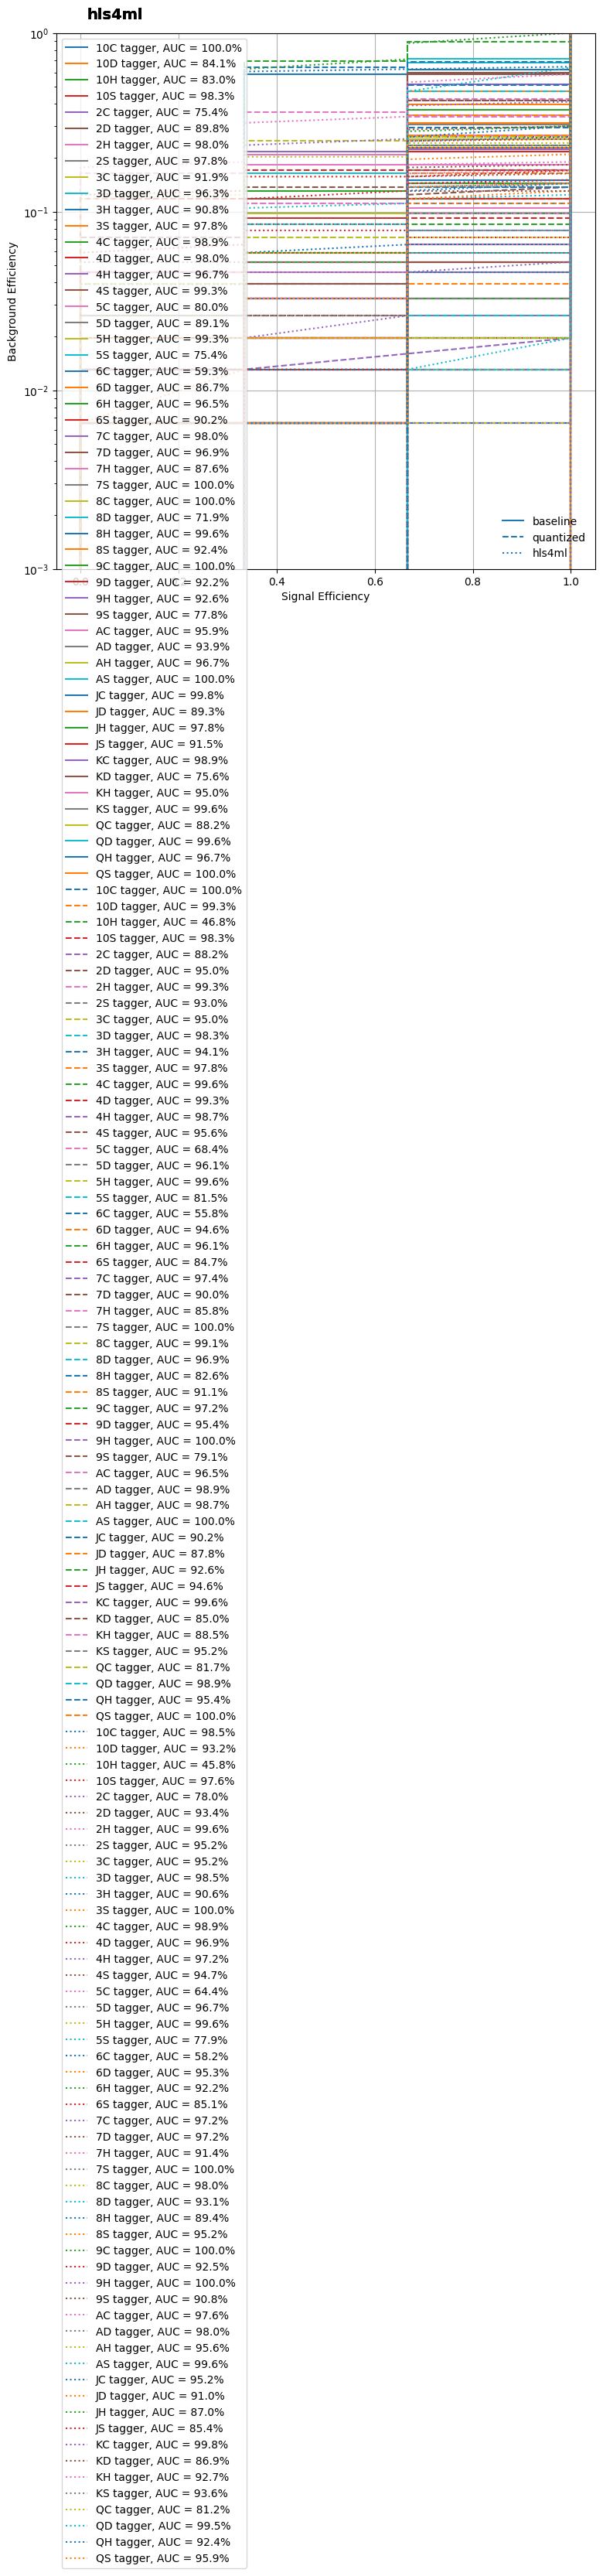

In [28]:
%matplotlib inline
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import load_model

model_ref = load_model('model_1/KERAS_check_best_model.h5')
y_ref = model_ref.predict(X_test)

print("Accuracy baseline:  {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_ref, axis=1))))
print("Accuracy quantized: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_ref, classes)
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_qkeras, classes, linestyle='--')
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, classes, linestyle=':')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--'), Line2D([0], [0], ls=':')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['baseline', 'quantized', 'hls4ml'], loc='lower right', frameon=False)
ax.add_artist(leg)